In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import torch.nn as nn
import torch

In [ ]:
skill = 5

alpha = 0.5#Consumption
beta = 0.5e-5 #Savings
gamma = 1e-2 #Inventory
risk = 0.8

no_households = 100
no_firms = 10
simulation_steps = 100


house_in = 4+no_firms
house_hidd = 32
house_out = 3

firm_in = 4
firm_hidd = 32
firm_out = 4

cycle  = 5
epochs = 30

interest_rate = 0.05

#Variables whihc help in training 
MAX_REWARD = 100

INITAL_MONEY = 10

#To assist training
MIN_PRICE = 1
MIN_WAGE = 1
MIN_CONSUMPTION = 1

In [3]:
#A simple neural network architecture
class genetic_network(nn.Module):
    def __init__(self,inp,hidd,out):
        super().__init__()
        self.architecture= nn.Sequential(
        nn.Linear(inp,hidd),
        nn.ReLU(),
        nn.Linear(hidd,out),
    
        )
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.uniform_(m.weight, a=-1.0, b=1.0)   
    def forward(self,x):
        logits = self.architecture(x)
        return logits
    
#A function to get the weights of the nn
def gene(network):
    flat_params = torch.cat([p.view(-1) for p in network.parameters()])
    return flat_params

def set_gene(gene,inp,hidd,out):
    model = genetic_network(inp,hidd,out)
    pointer = 0
    for param in model.parameters():
        numel = param.numel()
        new_values = gene[pointer:pointer+numel].view_as(param)
        with torch.no_grad():
            param.copy_(new_values)
        pointer+=numel
    return model

In [4]:
#Recombination strategies
def recombine_weighted(gene_a,gene_b,alpha):
    return (gene_a*alpha + (1-alpha)*gene_b,gene_b*alpha + (1-alpha)*gene_a)

#def 1 point crossover
def crossover(gene_a,gene_b):
    m = int(len(gene_a) / 2)
    child1 = torch.cat([gene_a[:m], gene_b[m:]], dim=0)
    child2 = torch.cat([gene_b[:m], gene_a[m:]], dim=0)
    return child1, child2
#Uniform crossover
def uniform_crossover(gene_a,gene_b):
    mask = torch.rand_like(gene_a,dtype=torch.float)<0.5
    child1 = torch.where(mask,gene_a,gene_b)
    child2 = torch.where(mask,gene_b,gene_a)
    return child1,child2 

#Random reset mutate
def random_reset(gene_a,prob):
    gene_a = gene_a.clone()
    for idx in range(gene_a.numel()):
        if(random.random()<prob):
            gene_a.view(-1)[idx] = random.uniform(-0.1,0.1)
    return gene_a

In [5]:
class Household:
    def __init__(self):
        self.savings = INITAL_MONEY
        input_len = house_in # savings, interest rate, tax rate, tax credit, prices,skill
        output_len = house_out #Min acceptable price, Amount to be bought, Minimum work wage
        self.reward = 0
        self.consumption = 0
        self.mind = genetic_network(input_len,house_hidd,output_len)
        
    def act(self,interest_rate,tax_rate_house,tax_credits,firms):
        #Generate interest
        self.savings = (1+interest_rate)*self.savings

        prices = torch.tensor([firm.price for firm in firms],dtype=torch.float32)
        input_data = torch.tensor(
            [self.savings, interest_rate, tax_rate_house, tax_credits],
            dtype=torch.float32
        )
        input_data = torch.cat([input_data, prices])
        self.output = self.mind(input_data)
        self.output = torch.clamp(self.output, min=0)

        self.max_price = self.output[0].item()
        self.amt_to_buy = self.output[1].item() + MIN_CONSUMPTION
        self.min_wage = self.output[2].item() + MIN_WAGE
        return self.output #(Max acceptable price, How much they wish to buy, Minimum wage)
       
    def comp_reward(self):
       #Simplified reward
       self.reward += alpha*pow(self.consumption,1-risk)/(1-risk) + beta * self.savings
       self.consumption = 0 #Reset it to 0
       self.reward = max(min(self.reward,MAX_REWARD),-MAX_REWARD)


In [6]:
#Firms
class Firm:
    def __init__(self):
        self.savings = INITAL_MONEY
        self.price = 0
        self.goods_inventory = 0
        input_len = firm_in # savings, interest rate, firm tax rate, firm tax credit
        output_len = firm_out #Min acceptable price, Maximum work wage, Max Employees (Each employee produces a fixed number of pdts)
        self.mind = genetic_network(input_len,firm_hidd,output_len)
        self.reward = 0
        
    def act(self,interest_rate,tax_rate_house,tax_credits):
        self.savings = (1+interest_rate)*self.savings
        input_data = torch.tensor(
            [self.savings, interest_rate, tax_rate_house, tax_credits],
            dtype=torch.float32
        )
        input_data = torch.cat([input_data])
        self.output = self.mind(input_data)
        self.output = torch.clamp(self.output, min=0)
        
        self.min_price = self.output[0].item() + MIN_PRICE
        self.max_wage = self.output[1].item()
        self.max_employees = self.output[2].item()
        return self.output
    
    def comp_reward(self):
       #Simplified reward
       self.reward += beta*self.savings - gamma * self.goods_inventory
       self.reward = max(min(self.reward,MAX_REWARD),-MAX_REWARD)
       

In [7]:
#Generate Households
#Formula for generating next generation
def generate_houses(group):
    group = sorted(group,key=lambda b:b.reward,reverse=True)
    new_group = []
    #Add the top 30%performers to the next group
    for i in range(0,int(0.3*len(group))):
        f = Household()
        f.mind = group[i].mind #Keep the same weights
        new_group.append(f)

    #Add some recombinations
    while len(new_group)<len(group):
        min_score = (min(f.reward for f in group)-0.1)
        chosen_one = random.choices(group, weights=[f.reward-min_score for f in group], k=1)[0]
        remaining = [f for f in group if f != chosen_one]
        remaining_weights = [f.reward-min_score for f in remaining]
        chosen_two = random.choices(remaining, weights=remaining_weights, k=1)[0]
        gene_a = gene(chosen_one.mind)
        gene_b = gene(chosen_two.mind)
        mutated = crossover(gene_a,gene_b)
        mutated2 = recombine_weighted(gene_a,gene_b,0.4)
        mutated3 = uniform_crossover(gene_a,gene_b)
        
        f = Household()
        f.mind = set_gene(random_reset(mutated[0],0.01),house_in,house_hidd,house_out)
        new_group.append(f) 
        f2 = Household()
        f2.mind = set_gene(random_reset(mutated[1],0.01),house_in,house_hidd,house_out)
        new_group.append(f2)
        
        f = Household()
        f.mind = set_gene(random_reset(mutated2[0],0.01),house_in,house_hidd,house_out)
        new_group.append(f) 
        f2 = Household()
        f2.mind = set_gene(random_reset(mutated2[1],0.01),house_in,house_hidd,house_out)
        new_group.append(f2)

        f = Household()
        f.mind = set_gene(random_reset(mutated3[0],0.01),house_in,house_hidd,house_out)
        new_group.append(f) 
        f2 = Household()
        f2.mind = set_gene(random_reset(mutated3[1],0.01),house_in,house_hidd,house_out)
        new_group.append(f2)
    return new_group[:len(group)]

#RESET HOUSES
def reset_houses(group):
    new_group = []
    for i in range(0,int(len(group))):
        f = Household()
        f.mind = group[i].mind #Keep the same weights
        new_group.append(f)
    return new_group


In [8]:
#Generate firms
def generate_firms(group):
    group = sorted(group,key=lambda b:b.reward,reverse=True)
    new_group = []
    #Add the top 30%performers to the next group
    for i in range(0,int(0.3*len(group))):
        f = Firm()
        f.mind = group[i].mind #Keep the same weights
        new_group.append(f)

    #Add some recombinations
    while len(new_group)<len(group):
        min_score = (min(f.reward for f in group)-0.1)
        chosen_one = random.choices(group, weights=[f.reward-min_score for f in group], k=1)[0]
        remaining = [f for f in group if f != chosen_one]
        remaining_weights = [f.reward-min_score for f in remaining]
        chosen_two = random.choices(remaining, weights=remaining_weights, k=1)[0]
        gene_a = gene(chosen_one.mind)
        gene_b = gene(chosen_two.mind)
        mutated = crossover(gene_a,gene_b)
        mutated2 = recombine_weighted(gene_a,gene_b,0.4)
        mutated3 = uniform_crossover(gene_a,gene_b)
        
        f = Firm()
        f.mind = set_gene(random_reset(mutated[0],0.01),firm_in,firm_hidd,firm_out)
        new_group.append(f) 
        f2 = Firm()
        f2.mind = set_gene(random_reset(mutated[1],0.01),firm_in,firm_hidd,firm_out)
        new_group.append(f2)
        
        f = Firm()
        f.mind = set_gene(random_reset(mutated2[0],0.01),firm_in,firm_hidd,firm_out)
        new_group.append(f) 
        f2 = Firm()
        f2.mind = set_gene(random_reset(mutated2[1],0.01),firm_in,firm_hidd,firm_out)
        new_group.append(f2)

        f = Firm()
        f.mind = set_gene(random_reset(mutated3[0],0.01),firm_in,firm_hidd,firm_out)
        new_group.append(f) 
        f2 = Firm()
        f2.mind = set_gene(random_reset(mutated3[1],0.01),firm_in,firm_hidd,firm_out)
        new_group.append(f2)
    return new_group[:len(group)]

#RESET FIRMS
def reset_firms(group):
    new_group = []
    for i in range(0,int(len(group))):
        f = Firm()
        f.mind = group[i].mind #Keep the same weights
        new_group.append(f)
    return new_group

In [9]:
# A function to monitor flow of goods and services
def work_trade(households,firms):
    #All households and firms act
    for f in firms:
        f.act(interest_rate,0,0)

    for h in households:
        h.act(interest_rate,0,0,firms)

    #Work loop
    for h in households:
        for f in firms:
            if(h.min_wage <= f.max_wage and f.max_employees >0):
                h.savings += f.max_wage
                f.savings -= f.max_wage
                f.max_employees -=1
                f.goods_inventory += skill
                break
            
    #Now for buying
    for h in households:
        
        for f in firms:
            if(h.amt_to_buy <= 0):
                break
            if(f.min_price<=h.max_price and h.amt_to_buy>0 and f.goods_inventory>0):
                purchase = max(min(h.amt_to_buy,f.goods_inventory),0)
                money = purchase*f.min_price

                f.goods_inventory -= purchase
                f.savings += money

                h.consumption += purchase
                h.savings -= money
                h.amt_to_buy -= purchase

                
                


In [10]:
house_rewards = []
firm_rewards = []
mean_household_savings = []
mean_firm_savings = []
mean_consumption = []
mean_inventory = []


#Initialize
households = []
for i in range(0,no_households):
    households.append(Household())

#Firms
firms = []
for i in range(0,no_firms):
    firms.append(Firm())

i = 0
for e in range(epochs):
    i += 1
    #Firm train cycle
    for t in range(simulation_steps):
        work_trade(households,firms)

    f_r = 0
    h_r = 0
    h_s = 0
    f_s = 0
    m_c = 0
    m_i = 0
 
    for f in firms:
        f_s += f.savings
        m_i += f.goods_inventory
        f.comp_reward()
        f_r += f.reward

    f_r /= len(firms)
    f_s /= len(firms)
    m_i /= len(firms)
    
    for h in households:
        m_c += h.consumption
        h_s += h.savings
        h.comp_reward()
        h_r += h.reward
        
        
    h_r /= len(households)
    h_s /= len(households)
    m_c /= len(households)

    print(f_r,h_r)
    house_rewards.append(h_r)
    firm_rewards.append(f_r)
    mean_household_savings.append(h_s)
    mean_firm_savings.append(f_s)
    mean_inventory.append(m_i)
    mean_consumption.append(m_c)

    if(i%(2*cycle) <cycle):
        print("HOUSEHOLD")
        households = generate_houses(households)
        firms = reset_firms(firms)
    else:
        print("FIRM")
        firms = generate_firms(firms)
        households = reset_houses(households)

-1.1993373656415327 98.0
HOUSEHOLD
-21.206748236236738 100.0
HOUSEHOLD
19.200048920567653 96.0
HOUSEHOLD
-0.20229381127179064 0.3472471287565442
HOUSEHOLD
-21.190792889167618 100.0
FIRM
-9.994082443396916 100.0
FIRM
-0.013830989390274787 0.6896159795621543
FIRM
-5.317436573140004 3.6679405416665025
FIRM
-0.22671423268325358 0.24098470653374693
FIRM
0.005939390069413714 0.4322111009580257
HOUSEHOLD
0.005939390069413714 0.5305160346934691
HOUSEHOLD
0.005939390069413714 0.5305160346934691
HOUSEHOLD
0.005939390069413714 0.5305160346934691
HOUSEHOLD
0.005939390069413714 0.5305160346934691
HOUSEHOLD
0.005939390069413714 0.5305160346934691
FIRM
-0.796560456569744 1.8638807318323058
FIRM
0.006575062892315202 0.006575062892315207
FIRM
0.006575062892315202 0.006575062892315207
FIRM
0.006575062892315202 0.006575062892315207
FIRM
-10.009370307521827 100.0
HOUSEHOLD
-10.009370307521827 100.0
HOUSEHOLD
-10.009370307521827 100.0
HOUSEHOLD
-10.009152605891085 100.0
HOUSEHOLD
-10.009370307521827 100.0


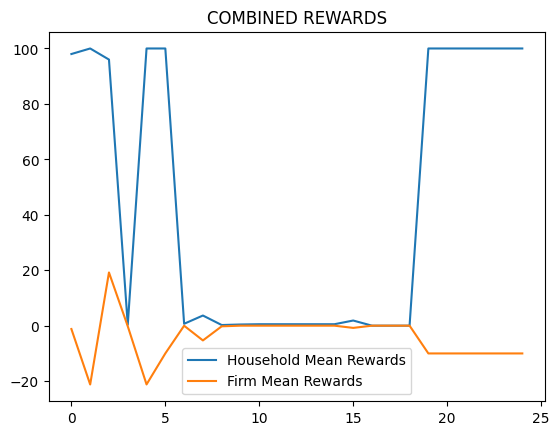

In [11]:
#Both being compared
plt.plot(house_rewards,label="Household Mean Rewards")
plt.plot(firm_rewards,label="Firm Mean Rewards")
plt.legend()
plt.title("COMBINED REWARDS")
plt.show()

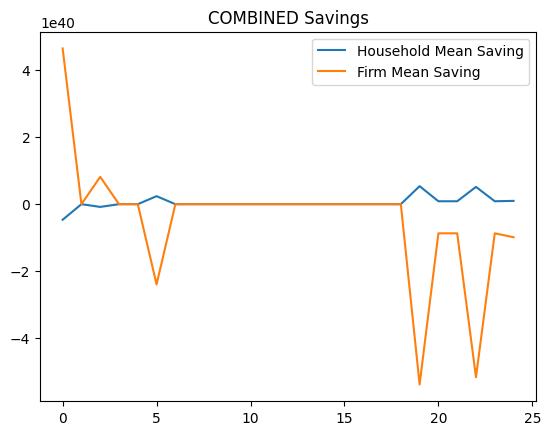

In [12]:
plt.plot(mean_household_savings,label="Household Mean Saving")
plt.plot(mean_firm_savings,label="Firm Mean Saving")
plt.legend()
plt.title("COMBINED Savings")
plt.show()

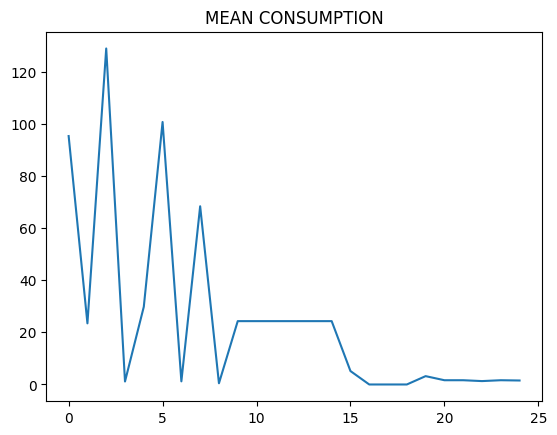

In [13]:
plt.plot(mean_consumption)
plt.title("MEAN CONSUMPTION")
plt.show()

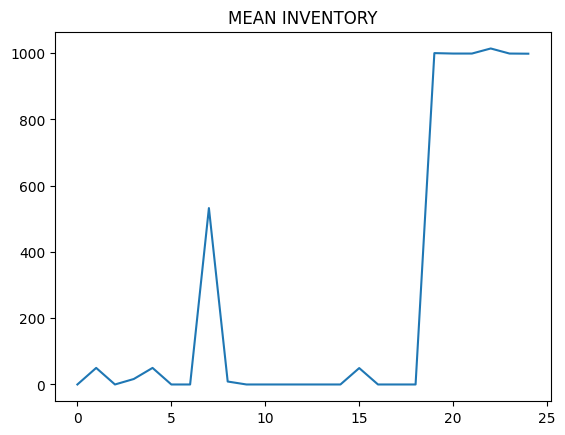

In [14]:
plt.plot(mean_inventory)
plt.title("MEAN INVENTORY")
plt.show()